<a href="https://colab.research.google.com/github/Vinnesta/l45-music-gnn/blob/main/L45_Mozart_is_a_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=green> Simple Model Architecture

Code Note:  
https://hackmd.io/@0Y_ZosHzSjKcz7sGAMMIXA/SyGTs-e6o/edit

## Environment set up

In [ ]:
# install packages
!pip install networkx

import torch
!pip install torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_scatter import scatter_mean, scatter_max, scatter_sum
from torch_geometric.utils.convert import from_scipy_sparse_matrix

import numpy as np
import random

#for nice visualisations
import networkx as nx
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html


## High parameter for data structure

In [ ]:
# High parameters for data structure
music_len = 100
time_steps = 5
number_nodes = 12

### Generate test code

In [ ]:
# functio which takes music sequence and window size(history length) and return training data.
# music = Time_step x Num_nodes
def slice_temporal_data(music_seq,window_size=5):
  return [[torch.transpose(music_seq[i:i+5],0,1),music_seq[i+5].reshape(-1,1)] for i in range(len(music_seq)-window_size)]


In [ ]:
# geberate toy music sequence and process it as traning data
toy_music = (torch.rand(music_len,number_nodes)<0.5).to(torch.float)
data = slice_temporal_data(toy_music,window_size=5)
print("Input: ",data[0][0])
print("Output: ",data[0][1])

Input:  tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 1., 0., 1.],
        [1., 0., 0., 0., 1.]])
Output:  tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]])


In [ ]:
# Toy adjacency matrix for testing
toy_adj_mat = (torch.rand(number_nodes,number_nodes)<0.5).to(torch.float)
print("Adjancy Matrix: ",toy_adj_mat)
print("Edge_index: ",toy_adj_mat.to_sparse())

toy_deg = torch.diag(torch.sum(toy_adj_mat, 1))
print("Degree Matrix: ",toy_deg)

Adjancy Matrix:  tensor([[0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
        [0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.],
        [1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.],
        [0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.]])
Edge_index:  tensor(indices=tensor([[ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,
                         2,  2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  5,  5,
                         5,  5,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,
                         8,  8,  

## Data Processing

In [ ]:
import torch

def create_tonnetz_adjacency_matrix(num_notes):
  # In Tonnetz, each node has six neighbours which have pitches of the following distances (in semi-tones)
  # E.g. C4 has neighbours F3, G#3, A3, D#4, E4, G4
  NEIGHBOUR_DISTANCES = [-7, -4, -3, 3, 4, 7]
  A = []

  for i in range(num_notes):
    row = torch.zeros(num_notes, dtype=torch.int)
    for d in NEIGHBOUR_DISTANCES:
      j = i+d
      if j >= 0 and j < num_notes:
        row[j] = 1
    A.append(row)
  return torch.stack(A)

A = create_tonnetz_adjacency_matrix(number_notes)

# Check that A is symmetric since the Tonnetz graph is undirected
assert(torch.equal(A, A.transpose(0, 1)))

## Model architecture examples

In [ ]:
from torch_geometric.nn import GCNConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Prepare dataset
May be need to do another batching methods. In current way, the node infmormation is separated, so that structural information is not well captured.

It should be;
- train_pred = model(X)[train_mask]
- train_label = label[train_mask]
- test_pred = model(X)[test_mask]
- test_label = label[test_mask]

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

data_X = torch.stack([d[0] for d in data])
y = torch.stack([d[1] for d in data])
#print(y.shape)
data_Y = np.zeros((y.shape[0],y.shape[1],2))
for i,nodes in enumerate(y):
  for j,node in enumerate(nodes):
    data_Y[i][j][int(node)] = 1.0
data_Y = torch.tensor(data_Y)
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.33, random_state=42)
print(X_train.shape)
print(y_train.shape)

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_test, y_test)

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

torch.Size([95, 12, 1])
torch.Size([63, 12, 5])
torch.Size([63, 12, 2])


### Model example 1

In [ ]:
class SimpleModel01(nn.Module):
    # input_dim = dim of node features
    # output_dim = number of class which is ON/OFF
    def __init__(self, adj_mat, input_dim, hidden_dim=0, output_dim=2):
        super(SimpleModel01, self).__init__()
        self.adj_mat = adj_mat
        self.edge_index = self.adj_mat.to_sparse().indices().to(device)
        #print(self.edge_index)
        
        # GCN layers
        self.gcn_conv1 = GCNConv(input_dim,output_dim)

    def forward(self, x):
        x = self.gcn_conv1(x,self.edge_index)
        y_hat = F.log_softmax(x)
        return y_hat


------------------------------------------------------
epoch 1/100
Train_Loss: 14.9252 Train_Acc: 6.2478
Test_Loss: 14.9552 Test_Acc: 0.1250

------------------------------------------------------
epoch 2/100
Train_Loss: 14.9270 Train_Acc: 5.8929
Test_Loss: 14.9511 Test_Acc: 0.1250

------------------------------------------------------
epoch 3/100
Train_Loss: 14.8850 Train_Acc: 6.3013
Test_Loss: 14.9458 Test_Acc: 0.1250

------------------------------------------------------
epoch 4/100
Train_Loss: 14.8963 Train_Acc: 5.9598
Test_Loss: 14.9424 Test_Acc: 0.1250

------------------------------------------------------
epoch 5/100
Train_Loss: 14.9020 Train_Acc: 5.9174
Test_Loss: 14.9405 Test_Acc: 0.1250

------------------------------------------------------
epoch 6/100


<ipython-input-125-af08e50a5694>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = F.log_softmax(x)


Train_Loss: 14.8868 Train_Acc: 5.9152
Test_Loss: 14.9385 Test_Acc: 0.1250

------------------------------------------------------
epoch 7/100
Train_Loss: 14.8821 Train_Acc: 6.2098
Test_Loss: 14.9388 Test_Acc: 0.1250

------------------------------------------------------
epoch 8/100
Train_Loss: 14.8752 Train_Acc: 5.9665
Test_Loss: 14.9384 Test_Acc: 0.1250

------------------------------------------------------
epoch 9/100
Train_Loss: 14.8749 Train_Acc: 5.8884
Test_Loss: 14.9384 Test_Acc: 0.0938

------------------------------------------------------
epoch 10/100
Train_Loss: 14.8775 Train_Acc: 6.0179
Test_Loss: 14.9375 Test_Acc: 0.0938

------------------------------------------------------
epoch 11/100
Train_Loss: 14.8714 Train_Acc: 5.8237
Test_Loss: 14.9380 Test_Acc: 0.0938

------------------------------------------------------
epoch 12/100
Train_Loss: 14.8767 Train_Acc: 6.0446
Test_Loss: 14.9390 Test_Acc: 0.0625

------------------------------------------------------
epoch 13/100
Tr

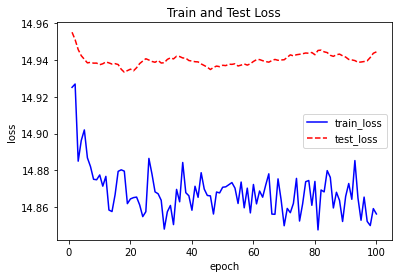

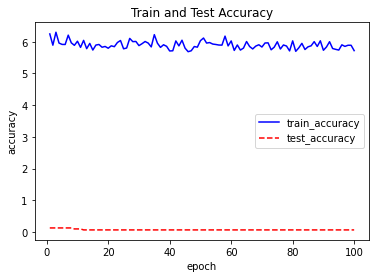

In [ ]:
net = SimpleModel01(toy_adj_mat,time_steps, output_dim=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epoch = 100

# learnig loop
# Training
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for i in range(epoch):
    print("\n------------------------------------------------------")
    print("epoch {}/{}".format(i+1,epoch))
    
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    
    net.train()
    for data,label in train_dataloader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        y_pred_prob = net(data)
        #print(y_pred_prob)
        loss = criterion(y_pred_prob,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        y_pred = torch.max(y_pred_prob,2)[1]                        #[1] is indicies of the resulting tensor
        label_max = torch.max(label)
        #print(y_pred.shape,label.shape)
        train_acc += torch.sum(y_pred==label_max).item()/len(label)
    batch_train_loss = train_loss/len(train_dataloader)
    batch_train_acc = train_acc/len(train_dataloader)
    
    net.eval()
    with torch.no_grad():
        for data,label in valid_dataloader:
            data = data.to(device)
            label = label.to(device)
            y_pred_prob = net(data)
            loss = criterion(y_pred_prob,label)
            test_loss += loss.item()
            y_pred = torch.max(y_pred_prob,1)[1]
            label_max = torch.max(label)
            test_acc += torch.sum(y_pred==label_max).item()/len(label)
    batch_test_loss = test_loss/len(valid_dataloader)
    batch_test_acc = test_acc/len(valid_dataloader)
    print("Train_Loss: {:.4f} Train_Acc: {:.4f}".format(batch_train_loss, batch_train_acc))
    print("Test_Loss: {:.4f} Test_Acc: {:.4f}".format(batch_test_loss,batch_test_acc))

    train_loss_list.append(batch_train_loss)
    train_acc_list.append(batch_train_acc)
    test_loss_list.append(batch_test_loss)
    test_acc_list.append(batch_test_acc)

# visualizing training process
plt.figure()
plt.title("Train and Test Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(range(1,epoch+1),train_loss_list,color="b",linestyle="-",label="train_loss")
plt.plot(range(1,epoch+1),test_loss_list,color="r",linestyle="--",label="test_loss")
plt.legend()
plt.figure()
plt.title("Train and Test Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(1,epoch+1),train_acc_list,color="b",linestyle="-",label="train_accuracy")
plt.plot(range(1,epoch+1),test_acc_list,color="r",linestyle="--",label="test_accuracy")
plt.legend()
plt.show()

### Model example 2

In [ ]:
class SimpleModel02(nn.Module):
    # input_dim = dim of node features
    # output_dim = number of class which is ON/OFF
    def __init__(self, adj_mat, input_dim, hidden_dim, output_dim=2):
        super(SimpleModel02, self).__init__()
        self.adj_mat = adj_mat
        self.edge_index = self.adj_mat.to_sparse().indices().to(device)
        
        # GCN layers
        self.gcn_conv1 = GCNConv(input_dim,hidden_dim)
        
        # Linear layers
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.gcn_conv1(x,self.edge_index)
        x = F.relu(x)
        y_hat = F.log_softmax(self.linear(x))
        return y_hat


------------------------------------------------------
epoch 1/100
Train_Loss: 14.9086 Train_Acc: 8.0402
Test_Loss: 14.9061 Test_Acc: 0.0312

------------------------------------------------------
epoch 2/100
Train_Loss: 14.9023 Train_Acc: 8.2589
Test_Loss: 14.9064 Test_Acc: 0.0000

------------------------------------------------------
epoch 3/100
Train_Loss: 14.8947 Train_Acc: 6.6830
Test_Loss: 14.9069 Test_Acc: 0.0312

------------------------------------------------------
epoch 4/100
Train_Loss: 14.8937 Train_Acc: 6.2076
Test_Loss: 14.9073 Test_Acc: 0.0625

------------------------------------------------------
epoch 5/100
Train_Loss: 14.8826 Train_Acc: 5.7969
Test_Loss: 14.9064 Test_Acc: 0.0625

------------------------------------------------------
epoch 6/100
Train_Loss: 14.8885 Train_Acc: 5.7701
Test_Loss: 14.9069 Test_Acc: 0.0625

------------------------------------------------------
epoch 7/100


<ipython-input-130-ebf8f0617d05>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = F.log_softmax(self.linear(x))


Train_Loss: 14.8780 Train_Acc: 5.8438
Test_Loss: 14.9087 Test_Acc: 0.0625

------------------------------------------------------
epoch 8/100
Train_Loss: 14.8744 Train_Acc: 5.8795
Test_Loss: 14.9111 Test_Acc: 0.0625

------------------------------------------------------
epoch 9/100
Train_Loss: 14.8804 Train_Acc: 6.0179
Test_Loss: 14.9152 Test_Acc: 0.0312

------------------------------------------------------
epoch 10/100
Train_Loss: 14.8772 Train_Acc: 6.1629
Test_Loss: 14.9171 Test_Acc: 0.0625

------------------------------------------------------
epoch 11/100
Train_Loss: 14.8828 Train_Acc: 5.9219
Test_Loss: 14.9168 Test_Acc: 0.0625

------------------------------------------------------
epoch 12/100
Train_Loss: 14.8820 Train_Acc: 5.8326
Test_Loss: 14.9167 Test_Acc: 0.0625

------------------------------------------------------
epoch 13/100
Train_Loss: 14.8788 Train_Acc: 5.9576
Test_Loss: 14.9176 Test_Acc: 0.0625

------------------------------------------------------
epoch 14/100
T

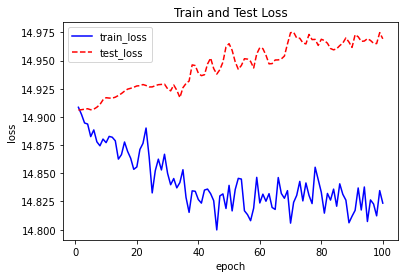

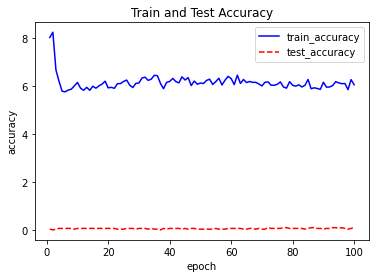

In [ ]:
net = SimpleModel02(toy_adj_mat,time_steps,3,output_dim=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epoch = 100

# learnig loop
# Training
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for i in range(epoch):
    print("\n------------------------------------------------------")
    print("epoch {}/{}".format(i+1,epoch))
    
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    
    net.train()
    for data,label in train_dataloader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        y_pred_prob = net(data)
        #print(y_pred_prob)
        loss = criterion(y_pred_prob,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        y_pred = torch.max(y_pred_prob,2)[1]                        #[1] is indicies of the resulting tensor
        label_max = torch.max(label)
        #print(y_pred.shape,label.shape)
        train_acc += torch.sum(y_pred==label_max).item()/len(label)
    batch_train_loss = train_loss/len(train_dataloader)
    batch_train_acc = train_acc/len(train_dataloader)
    
    net.eval()
    with torch.no_grad():
        for data,label in valid_dataloader:
            data = data.to(device)
            label = label.to(device)
            y_pred_prob = net(data)
            loss = criterion(y_pred_prob,label)
            test_loss += loss.item()
            y_pred = torch.max(y_pred_prob,1)[1]
            label_max = torch.max(label)
            test_acc += torch.sum(y_pred==label_max).item()/len(label)
    batch_test_loss = test_loss/len(valid_dataloader)
    batch_test_acc = test_acc/len(valid_dataloader)
    print("Train_Loss: {:.4f} Train_Acc: {:.4f}".format(batch_train_loss, batch_train_acc))
    print("Test_Loss: {:.4f} Test_Acc: {:.4f}".format(batch_test_loss,batch_test_acc))

    train_loss_list.append(batch_train_loss)
    train_acc_list.append(batch_train_acc)
    test_loss_list.append(batch_test_loss)
    test_acc_list.append(batch_test_acc)

# visualizing training process
plt.figure()
plt.title("Train and Test Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(range(1,epoch+1),train_loss_list,color="b",linestyle="-",label="train_loss")
plt.plot(range(1,epoch+1),test_loss_list,color="r",linestyle="--",label="test_loss")
plt.legend()
plt.figure()
plt.title("Train and Test Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(1,epoch+1),train_acc_list,color="b",linestyle="-",label="train_accuracy")
plt.plot(range(1,epoch+1),test_acc_list,color="r",linestyle="--",label="test_accuracy")
plt.legend()
plt.show()

### Model example 3

In [ ]:
class SimpleModel03(nn.Module):
    # input_dim = dim of node features
    # output_dim = number of class which is ON/OFF
    def __init__(self, adj_mat, input_dim, hidden_dim, output_dim=2):
        super(SimpleModel03, self).__init__()
        self.adj_mat = adj_mat
        self.edge_index = self.adj_mat.to_sparse().indices().to(device)
        
        # GCN layers
        self.gcn_conv1 = GCNConv(input_dim,hidden_dim)
        self.gcn_conv2 = GCNConv(hidden_dim,hidden_dim)
        
        # Linear layers
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.gcn_conv1(x,self.edge_index)
        x = F.relu(x)
        x = self.gcn_conv2(x,self.edge_index)
        x = F.relu(x)
        y_hat = F.log_softmax(self.linear(x))
        return y_hat


------------------------------------------------------
epoch 1/100
Train_Loss: 14.9088 Train_Acc: 5.0513
Test_Loss: 14.9168 Test_Acc: 0.1250

------------------------------------------------------
epoch 2/100
Train_Loss: 14.9053 Train_Acc: 5.3438
Test_Loss: 14.9212 Test_Acc: 0.1562

------------------------------------------------------
epoch 3/100
Train_Loss: 14.9003 Train_Acc: 5.6607
Test_Loss: 14.9222 Test_Acc: 0.1562

------------------------------------------------------
epoch 4/100
Train_Loss: 14.8943 Train_Acc: 6.2679
Test_Loss: 14.9279 Test_Acc: 0.1250

------------------------------------------------------
epoch 5/100
Train_Loss: 14.8832 Train_Acc: 6.3482
Test_Loss: 14.9278 Test_Acc: 0.1562

------------------------------------------------------
epoch 6/100
Train_Loss: 14.8786 Train_Acc: 6.2656
Test_Loss: 14.9298 Test_Acc: 0.1562

------------------------------------------------------
epoch 7/100
Train_Loss: 14.8807 Train_Acc: 6.2031
Test_Loss: 14.9321 Test_Acc: 0.1250


<ipython-input-130-ebf8f0617d05>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = F.log_softmax(self.linear(x))



------------------------------------------------------
epoch 8/100
Train_Loss: 14.8766 Train_Acc: 6.4576
Test_Loss: 14.9331 Test_Acc: 0.1250

------------------------------------------------------
epoch 9/100
Train_Loss: 14.8791 Train_Acc: 6.4062
Test_Loss: 14.9339 Test_Acc: 0.1250

------------------------------------------------------
epoch 10/100
Train_Loss: 14.8694 Train_Acc: 6.5067
Test_Loss: 14.9356 Test_Acc: 0.1250

------------------------------------------------------
epoch 11/100
Train_Loss: 14.8630 Train_Acc: 6.2210
Test_Loss: 14.9344 Test_Acc: 0.1562

------------------------------------------------------
epoch 12/100
Train_Loss: 14.8683 Train_Acc: 6.0759
Test_Loss: 14.9358 Test_Acc: 0.1875

------------------------------------------------------
epoch 13/100
Train_Loss: 14.8684 Train_Acc: 6.0938
Test_Loss: 14.9377 Test_Acc: 0.1250

------------------------------------------------------
epoch 14/100
Train_Loss: 14.8669 Train_Acc: 6.0379
Test_Loss: 14.9377 Test_Acc: 0.1562



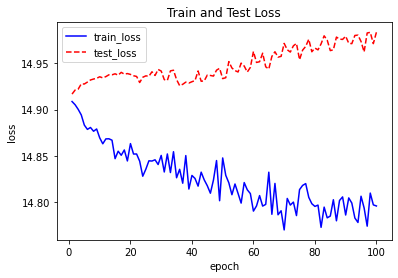

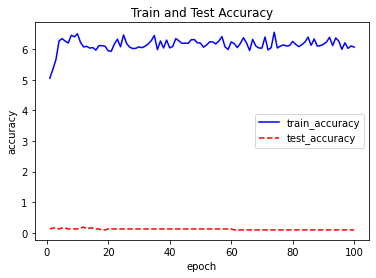

In [ ]:
net = SimpleModel02(toy_adj_mat,time_steps,3,output_dim=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epoch = 100

# learnig loop
# Training
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for i in range(epoch):
    print("\n------------------------------------------------------")
    print("epoch {}/{}".format(i+1,epoch))
    
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    
    net.train()
    for data,label in train_dataloader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        y_pred_prob = net(data)
        #print(y_pred_prob)
        loss = criterion(y_pred_prob,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        y_pred = torch.max(y_pred_prob,2)[1]                        #[1] is indicies of the resulting tensor
        label_max = torch.max(label)
        #print(y_pred.shape,label.shape)
        train_acc += torch.sum(y_pred==label_max).item()/len(label)
    batch_train_loss = train_loss/len(train_dataloader)
    batch_train_acc = train_acc/len(train_dataloader)
    
    net.eval()
    with torch.no_grad():
        for data,label in valid_dataloader:
            data = data.to(device)
            label = label.to(device)
            y_pred_prob = net(data)
            loss = criterion(y_pred_prob,label)
            test_loss += loss.item()
            y_pred = torch.max(y_pred_prob,1)[1]
            label_max = torch.max(label)
            test_acc += torch.sum(y_pred==label_max).item()/len(label)
    batch_test_loss = test_loss/len(valid_dataloader)
    batch_test_acc = test_acc/len(valid_dataloader)
    print("Train_Loss: {:.4f} Train_Acc: {:.4f}".format(batch_train_loss, batch_train_acc))
    print("Test_Loss: {:.4f} Test_Acc: {:.4f}".format(batch_test_loss,batch_test_acc))

    train_loss_list.append(batch_train_loss)
    train_acc_list.append(batch_train_acc)
    test_loss_list.append(batch_test_loss)
    test_acc_list.append(batch_test_acc)

# visualizing training process
plt.figure()
plt.title("Train and Test Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(range(1,epoch+1),train_loss_list,color="b",linestyle="-",label="train_loss")
plt.plot(range(1,epoch+1),test_loss_list,color="r",linestyle="--",label="test_loss")
plt.legend()
plt.figure()
plt.title("Train and Test Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(1,epoch+1),train_acc_list,color="b",linestyle="-",label="train_accuracy")
plt.plot(range(1,epoch+1),test_acc_list,color="r",linestyle="--",label="test_accuracy")
plt.legend()
plt.show()